In this notebook, I solve the alternative HW1 for Kyle Herkenhoff's Macro Labour class. In this homework, we are asked to solve a simple Bewley model.

In [1]:
using LinearAlgebra, Optim, Plots, Roots, Interpolations

In [2]:
# Params = [beta, gamma]
Params = Vector{Float64}([0.9, 1.0])
# Sizes = [grid_expansion_factor, number_of_states, number_of_actions]
Sizes = Vector{Int64}([2, 2, 101])

3-element Vector{Int64}:
   2
   2
 101

In [75]:
function expanding_grid(S)

    zero_grid = LinRange(0, 1, S[3])

    asset_grid = zeros(S[3], 1)

    a_low = 0.0

    a_high = 5.0

    for i in 1:S[3]

        asset_grid[i] = (zero_grid[i]^S[1]) * (a_high - a_low) + a_low

    end

    return asset_grid

end

expanding_grid (generic function with 1 method)

In [76]:
function states(S)

    states = range(exp(1), exp(2), S[2])

    transition = zeros(S[2], S[2])

    for i in 1:S[2]

        for j in 1:S[2]

            transition[i,j] = 1/S[2]

        end
    
    end

    return states, transition

end

states (generic function with 1 method)

In [77]:
function generate_matrices(S, P)

    value = zeros(S[3], S[2])

    policy = zeros(S[3], S[2])

    return value, policy

end

generate_matrices (generic function with 1 method)

In [80]:
function Bellman_grid_search(S, P, tolerance, max_iterations, q)

    iter = 0

    println("Iterating...")

    state, transition = states(S)

    bond_grid = expanding_grid(S)

    error = tolerance + 1

    Val, Pol = generate_matrices(S, P)

    V_old = similar(Val)

    V_new = similar(Val)

    expected_value = similar(Val)

    util = similar(Val)

    while (error > tolerance) && (max_iterations > 0)

    #for j in 1:S[2]

        for i in 1:S[3]

            consumption = bond_grid[i] .+ state .- (q .* bond_grid')

            c_positive = consumption .> 0

            consumption_positive = consumption .* c_positive

            expected_value = (V_old * transition)

            util =  log.(consumption_positive')

            Val = util .+ P[1] * expected_value

            Val[.!c_positive'] .= -Inf 

            V_new[i,:], vmax_indices = findmax(Val, dims=1)

            index = [vmax_indices[1][1], vmax_indices[2][1]]

            Pol[i,:] = bond_grid[index]

        end

        error = maximum(abs.(V_new - V_old))

        V_old = copy(V_new)

        if isinteger(iter/25) == true
            println("iteration $iter completed with error $error")
        end

        iter += 1

    end

    println("converged in $iter iterations")
    
    v = Plots.plot(bond_grid, V_new[:,1], title="Value Functions", label="Value 1")

    Plots.plot!(bond_grid, V_new[:,2], title="Value Functions", label="Value 2")

    display(v)

    p = Plots.plot(bond_grid, Pol[:,1], title="Policy Functions", label="Policy 1")

    Plots.plot!(p, [0, 5], [0, 5], color=:black, label="45-degree line")

    Plots.plot!(bond_grid, Pol[:,2], title="Policy Functions", label="Policy 2")

    display(p)
    
    return V_new, Pol

end

Bellman_grid_search (generic function with 1 method)

Iterating...
iteration 0 completed with error Inf
iteration 25 completed with error 0.09954508575441423
iteration 50 completed with error 0.007146321590639104
iteration 75 completed with error 0.0005130329889375673
iteration 100 completed with error 3.683053504133227e-5
iteration 125 completed with error 2.64405670336032e-6
iteration 150 completed with error 1.8981630489633972e-7
iteration 175 completed with error 1.3626877404249171e-8
converged in 179 iterations
  1.127445 seconds (714.39 k allocations: 226.856 MiB, 0.98% gc time, 78.80% compilation time)


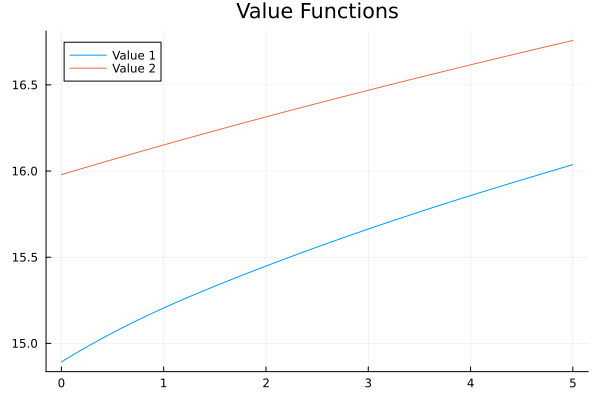

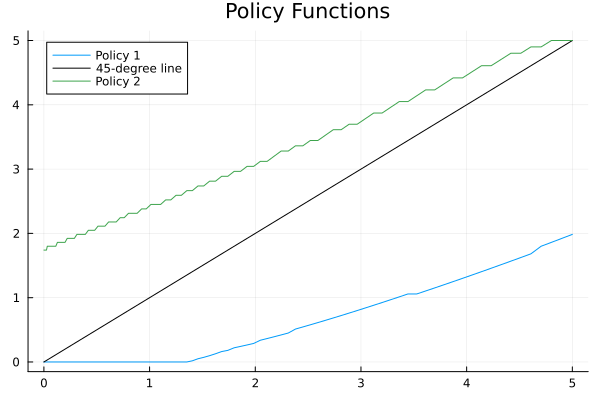

([14.892026550424223 15.97914358149759; 14.892210473229973 15.979232095776815; … ; 16.01961713742854 16.743960117309296; 16.03696581032792 16.75751746492177], [0.0 1.7405; 0.0 1.7405; … ; 1.9220000000000002 5.0; 1.9845000000000002 5.0])

In [81]:
@time begin
Value, Policy = Bellman_grid_search(Sizes, Params, 1e-8, 10000, 1)
end

In [98]:
function clear_markets(S, P)

    index = zeros(S[3], S[2])

    state, transition = states(S)

    bond_grid = expanding_grid(S)

    q_low = P[1]

    q_high = 1.3*P[1]

    q_update = (q_low + q_high) / 2

    Value, Policy = Bellman_grid_search(Sizes, Params, 1e-8, 10000, q_update)

    M = zeros(S[3], S[2], S[3], S[2])

    for i in 1:S[3]

        for j in 1:S[2]

        index[i,j] = findfirst(isequal(Policy[i,j]), bond_grid)[1]

        end

    end

    for i in 1:S[3]

        for j in 1:S[2]

            for k in 1:S[3]

                for l in 1:S[2]

                    if Policy[i,j] == bond_grid[k]

                        M[i,j,k,l] = 1/S[2]

                    else 

                        M[i,j,k,l] = 0

                    end

                end

            end

        end

    end

    O = reshape(M, (S[3]*S[2], S[3]*S[2]))

    

    #display(O)

    #number_of_states = S[3]*S[2]

    #non_zero_exists = any(O .== 1/2)

    #println("Non-zero elements in the transition matrix: ", non_zero_exists)

    #row_sums = sum(O, dims=2)

    #println("Row sums: ", row_sums)

    #zero_row_exists = any(sum(O, dims=2) .< 1)

    #println("Zero row exists: ", zero_row_exists)
    
    #for i in 1:number_of_states

        #O[i, :] = (O[i, :]) ./ sum(O, dims=2)[i]

    #end

    # Julia has a built-in function to calculate the eigenvalues and eigenvectors of a matrix
    #eigvals, eigvecs = eigen(O).values, eigen(O).vectors

    # Find the index of the unit eigenvalue
    #unit_eigenvalue_index = findfirst(x -> abs(x) == 1, eigvals)

    #if unit_eigenvalue_index !== nothing
        # Extract the eigenvector corresponding to the unit eigenvalue
        #stationary_distribution = eigvecs[:, unit_eigenvalue_index]

    #else

        #println("No unit eigenvalue found.")

    #end

    return O
    
end
    

clear_markets (generic function with 1 method)

Iterating...
iteration 0 completed with error 0.6617242126719276
iteration 25 completed with error 0.01119725536711158
iteration 50 completed with error 0.0008038487077577372
iteration 75 completed with error 5.770813697481003e-5
iteration 100 completed with error 4.14285554484195e-6
iteration 125 completed with error 2.9741477192146704e-7
iteration 150 completed with error 2.1351350909526445e-8
converged in 159 iterations


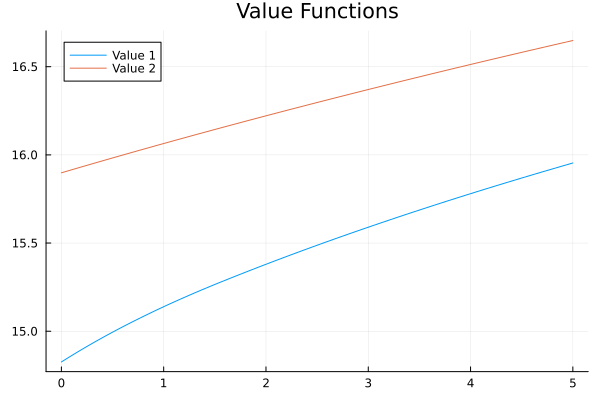

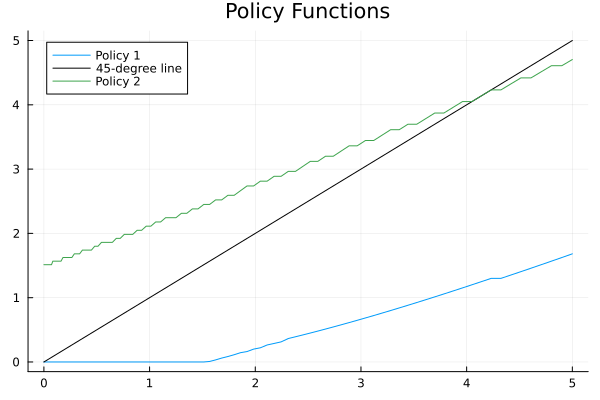

202×202 Matrix{Float64}:
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [99]:
ind = clear_markets(Sizes, Params)

In [84]:
function clear_markets_trial(S, P)

    index = zeros(S[3], S[2])

    state, transition = states(S)

    bond_grid = expanding_grid(S)

    q_low = P[1]

    q_high = 1.3*P[1]

    q_update = (q_low + q_high) / 2

    Value, Policy = Bellman_grid_search(Sizes, Params, 1e-8, 10000, q_update)

    M = zeros(S[3], S[2], S[3], S[2])

    for i in 1:S[3]

        for j in 1:S[2]

        index[i,j] = findfirst(isequal(Policy[i,j]), bond_grid)[1]

        end

    end

    return index

end

clear_markets_trial (generic function with 1 method)

Iterating...
iteration 0 completed with error 7.159314371368225
iteration 25 completed with error 0.07365751371735918
iteration 50 completed with error 0.005287858082439811
iteration 75 completed with error 0.0003796142676613101
iteration 100 completed with error 2.7252431891611195e-5
iteration 125 completed with error 1.9564466064991848e-6
iteration 150 completed with error 1.4045291152342543e-7
iteration 175 completed with error 1.0083091694923496e-8
converged in 177 iterations


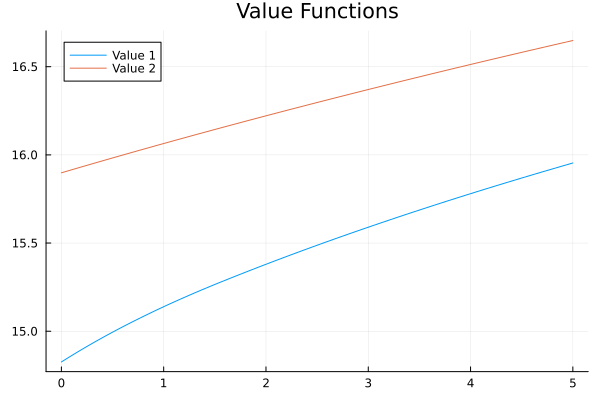

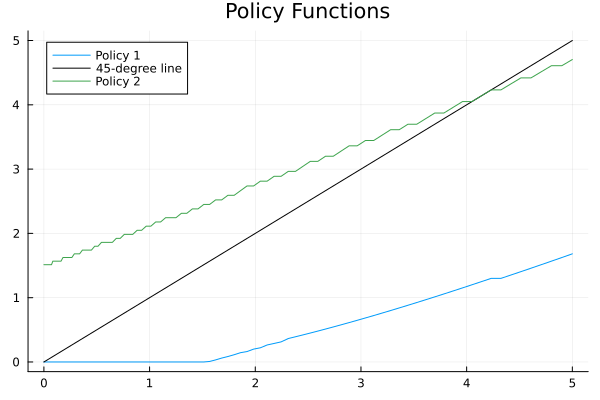

101×2 Matrix{Float64}:
  1.0  56.0
  1.0  56.0
  1.0  56.0
  1.0  56.0
  1.0  56.0
  1.0  56.0
  1.0  56.0
  1.0  56.0
  1.0  56.0
  1.0  56.0
  ⋮    
 52.0  93.0
 52.0  93.0
 53.0  94.0
 54.0  95.0
 55.0  95.0
 56.0  96.0
 57.0  97.0
 58.0  97.0
 59.0  98.0

In [85]:
ind = clear_markets_trial(Sizes, Params)